In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, matthews_corrcoef,mean_squared_error,balanced_accuracy_score,auc, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [ ]:
# Load the training and test data from the uploaded files
Xtrain = pd.read_csv('/content/Xtrain.csv',header=None, delim_whitespace=True)
Ytrain = pd.read_csv('/content/Ytrain.csv',header=None, delim_whitespace=True)
Xtest = pd.read_csv('/content/Xtest.csv',header=None, delim_whitespace=True)

In [ ]:
# Count the number of examples in each dataset
num_training_examples = Xtrain.shape[0]
num_test_examples = Xtest.shape[0]
print("Number of examples in training set :",num_training_examples)
print("Number of examples in testing set :",num_test_examples)

Number of examples in training set : 3000
Number of examples in testing set : 3000


In [ ]:
# Analyze the distribution of positive and negative labels in the training data
positive_labels = Ytrain[Ytrain.iloc[:, 0] == 1].count()[0]
negative_labels = Ytrain[Ytrain.iloc[:, 0] == -1].count()[0]
print("Number of positive examples  :",positive_labels)
print("Number of negative examples  :",negative_labels)

Number of positive examples  : 311
Number of negative examples  : 2689


Visual Data Exploration



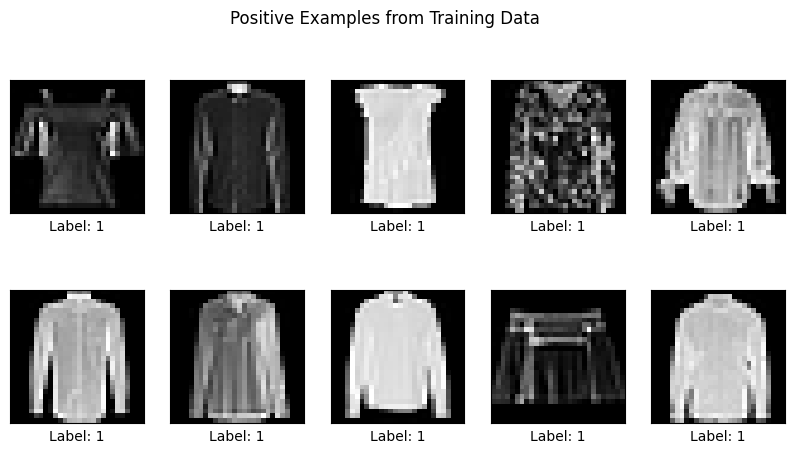

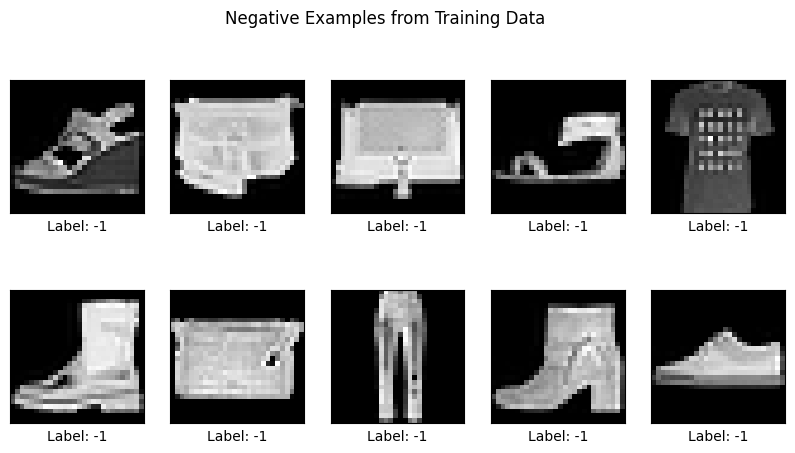

In [ ]:
# Function to display images
def display_images(data, indices, title):
    plt.figure(figsize=(10,5))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data.iloc[idx].values.reshape(28, 28), cmap=plt.cm.gray)
        plt.xlabel(f"Label: {Ytrain.iloc[idx, 0]}")
    plt.suptitle(title)
    plt.show()

# Randomly select 10 indices from each class
positive_indices = Ytrain[Ytrain.iloc[:, 0] == 1].index
negative_indices = Ytrain[Ytrain.iloc[:, 0] == -1].index

random_positive_indices = random.sample(list(positive_indices), 10)
random_negative_indices = random.sample(list(negative_indices), 10)

# Display the images
display_images(Xtrain, random_positive_indices, "Positive Examples from Training Data")
display_images(Xtrain, random_negative_indices, "Negative Examples from Training Data")


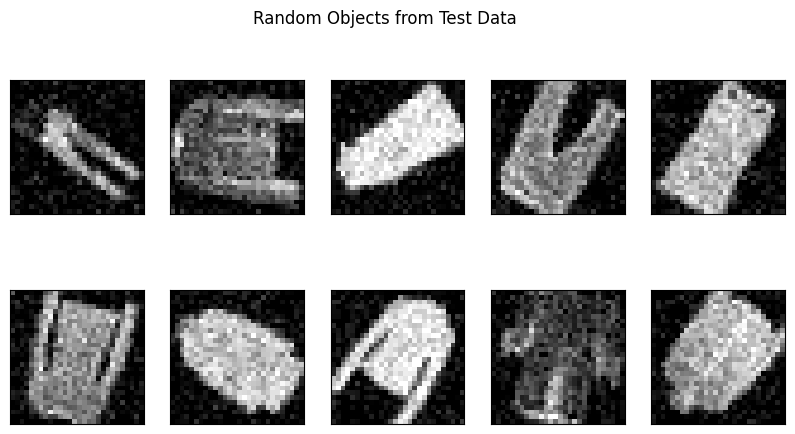

In [ ]:
# Function to display images
def display_test_images(data, title, n=10):
    random_indices = random.sample(range(data.shape[0]), n)
    images = data.iloc[random_indices].values.reshape(-1, 28, 28)  # Reshape the flat images

    # Plotting the images
    plt.figure(figsize=(10,5))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
    plt.suptitle(title)
    plt.show()

# Display 10 random images from the test set
display_test_images(Xtest, "Random Objects from Test Data")

In [ ]:
# Split the training data into a training set and a validation set
Xtrain, X_val, Ytrain, Y_val = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

# Instantiate and train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(Xtrain, Ytrain)

# Predict on the validation set
Y_pred = clf.predict(X_val)
Y_pred_proba = clf.predict_proba(X_val)[:, 1]  # Probability estimates for the positive class

# Calculate various metrics
accuracy = accuracy_score(Y_val, Y_pred)
auc_roc = roc_auc_score(Y_val, Y_pred_proba)
auc_pr = average_precision_score(Y_val, Y_pred_proba)
f1 = f1_score(Y_val, Y_pred)
mcc = matthews_corrcoef(Y_val, Y_pred)
mse = mean_squared_error(Y_val,Y_pred)


# Print the metrics
print("The accuracy:",accuracy)
print("The AUC_ROC:",auc_roc)
print("The AUC_PR:",auc_pr)
print("The F1:",f1)
print("The Matthews correlation coefficient:",mcc)
print("The Mean squared error:",mse)


<ipython-input-7-25eee290ffdb>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(Xtrain, Ytrain)


The accuracy: 0.9166666666666666
The AUC_ROC: 0.8913766921908824
The AUC_PR: 0.5499875626420814
The F1: 0.2857142857142857
The Matthews correlation coefficient: 0.3421961360993718
The Mean squared error: 0.3333333333333333


In [ ]:
# Proportions of classes in the training dataset
proportion_positive_train = positive_labels / num_training_examples  # Proportion of majority class (negative)
proportion_negative_train = negative_labels / num_test_examples  # Proportion of minority class (positive)

# Assuming similar proportions for the testing dataset, Accuracy is derived by,
accuracy_train = proportion_positive_train**2 + proportion_negative_train**2
print("Expected accuracy on training and testing dataset : ", accuracy_train)

Expected accuracy on training and testing dataset :  0.8141602222222222


In [ ]:

from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(Xtrain, Ytrain)
y_pred_proba_dummy = dummy_clf.predict_proba(X_val)[:, 1]

# Calculate ROC AUC for the random classifier
fpr, tpr, thresholds = roc_curve(Y_val, y_pred_proba_dummy)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall AUC for the random classifier
precision, recall, _ = precision_recall_curve(Y_val, y_pred_proba_dummy)
pr_auc = auc(recall, precision)


print(f'AUC-ROC: {roc_auc}')
print(f'AUC-PR: {pr_auc}')

AUC-ROC: 0.5
AUC-PR: 0.5475


In [ ]:
Xtrain_adjusted = Xtrain.iloc[:1000, :]

# Placeholder for metric collections
accuracy_scores = []
balanced_accuracy_scores = []
auc_roc_scores = []
auc_pr_scores = []
f1_scores = []
mcc_scores = []

# Defining 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Loop through the folds
for train_idx, test_idx in cv.split(Xtrain, Ytrain):
    # Splitting the data
    X_train_fold, X_test_fold = Xtrain.iloc[train_idx], Xtrain.iloc[test_idx]
    Y_train_fold, Y_test_fold = Ytrain.iloc[train_idx], Ytrain.iloc[test_idx]

    # Initialize and fit the KNN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_fold, Y_train_fold)

    # Making predictions
    Y_pred = knn.predict(X_test_fold)
    Y_pred_proba = knn.predict_proba(X_test_fold)[:, 1]
    # Calculating metrics
    accuracy_scores.append(accuracy_score(Y_test_fold, Y_pred))
    balanced_accuracy_scores.append(balanced_accuracy_score(Y_test_fold, Y_pred))
    auc_roc_scores.append(roc_auc_score(Y_test_fold, Y_pred_proba))
    auc_pr_scores.append(average_precision_score(Y_test_fold, Y_pred_proba))
    f1_scores.append(f1_score(Y_test_fold, Y_pred))
    mcc_scores.append(matthews_corrcoef(Y_test_fold, Y_pred))

# Calculating mean and standard deviation for each metric

    acc_mean= (np.mean(accuracy_scores))
    acc_std =(np.std(accuracy_scores))
    Balanced_Accuracy_mean=(np.mean(balanced_accuracy_scores))
    Balanced_Accuracy_std=(np.std(balanced_accuracy_scores))
    AUC_ROC_mean = (np.mean(auc_roc_scores))
    AUC_ROC_std = (np.std(auc_roc_scores))
    AUC_PR_mean = (np.mean(auc_pr_scores))
    AUC_PR_std = (np.std(auc_pr_scores))
    F1_Score_mean = (np.mean(f1_scores))
    F1_Score_std = (np.std(f1_scores))
    MCC_mean = (np.mean(mcc_scores))
    MCC_std = (np.std(mcc_scores))

data = {
    'Metric': ['Accuracy', 'Balanced Accuracy', 'AUC ROC', 'AUC PR', 'F1 Score', 'MCC'],
    'Mean': [acc_mean, Balanced_Accuracy_mean, AUC_ROC_mean, AUC_PR_mean, F1_Score_mean, MCC_mean],
    'Standard Deviation': [acc_std, Balanced_Accuracy_std, AUC_ROC_std, AUC_PR_std, F1_Score_std, MCC_std]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print DataFrame
print(df)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

              Metric      Mean  Standard Deviation
0           Accuracy  0.910833            0.009807
1  Balanced Accuracy  0.740132            0.029059
2            AUC ROC  0.879904            0.027704
3             AUC PR  0.548997            0.061830
4           F1 Score  0.553710            0.048853
5                MCC  0.506380            0.054067


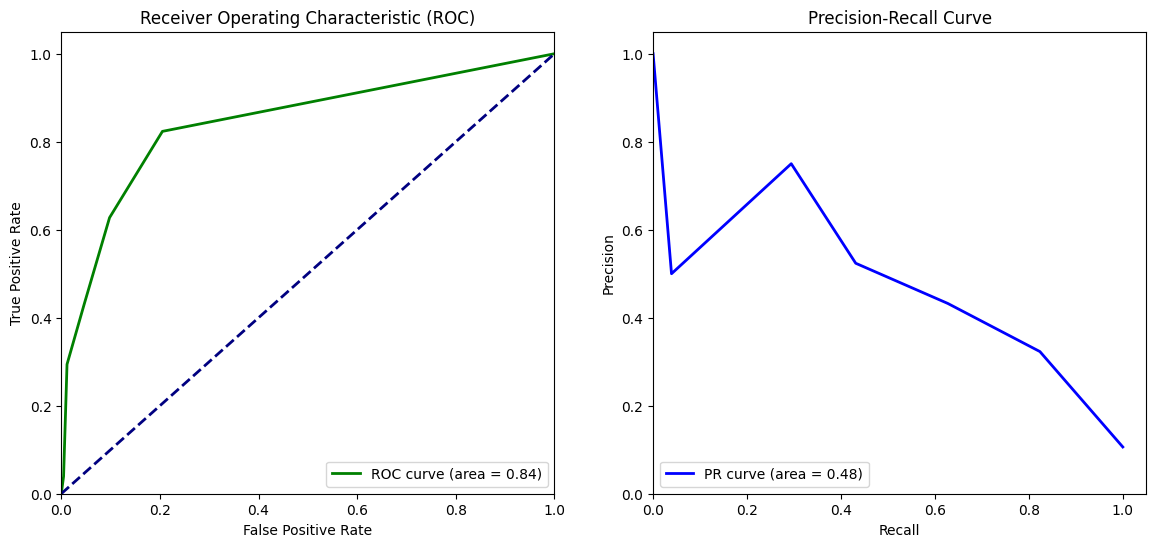

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(Y_test_fold, Y_pred_proba)
roc_auc = auc(fpr, tpr)

# PR Curve
precision, recall, _ = precision_recall_curve(Y_test_fold, Y_pred_proba)
pr_auc = auc(recall, precision)

# Plotting both curves
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax[0].plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC)')
ax[0].legend(loc="lower right")

# PR Curve
ax[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
ax[1].set_xlim([0.0, 1.05])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend(loc="lower left")

plt.show()



In [ ]:
Ytrain = Ytrain.values.ravel()
Xtrain_adjusted = Xtrain.iloc[:1000, :]
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Initialize the k-5 nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling
X_standard_scaled = standard_scaler.fit_transform(Xtrain)
std_scores = cross_val_score(knn, X_standard_scaled, Ytrain, cv=cv)
std_mean, std_std = std_scores.mean(), std_scores.std()

# Apply Min-Max Scaling
X_minmax_scaled = minmax_scaler.fit_transform(Xtrain)
minmax_scores = cross_val_score(knn, X_minmax_scaled, Ytrain, cv=cv)
minmax_mean, minmax_std = minmax_scores.mean(), minmax_scores.std()

# No Scaling
none_scores = cross_val_score(knn, Xtrain, Ytrain, cv=cv)
none_mean, none_std = none_scores.mean(), none_scores.std()

# Results in a table format
print(f"Standard Scaling Mean Accuracy: {std_mean}, Standard Deviation: {std_std}")
print(f"Min-Max Scaling Mean Accuracy: {minmax_mean}, Standard Deviation: {minmax_std}")
print(f"No Scaling Mean Accuracy: {none_mean}, Standard Deviation: {none_std}")


Standard Scaling Mean Accuracy: 0.9104166666666667, Standard Deviation: 0.005892556509887875
Min-Max Scaling Mean Accuracy: 0.9104166666666668, Standard Deviation: 0.008838834764831844
No Scaling Mean Accuracy: 0.9108333333333334, Standard Deviation: 0.009807168579949848


In [ ]:
Xtrain, Xtest, Ytrain, y_test = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# SVM Parameter Grid
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'probability': [True]
}

# Random Forest Parameter Grid
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}
# Initialize stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for SVM
svm_grid = GridSearchCV(SVC(), svm_params, scoring='accuracy', cv=cv, verbose=1)
svm_grid.fit(X_train_scaled, Ytrain)

# Grid search for Random Forest
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring='accuracy', cv=cv, verbose=1)
rf_grid.fit(X_train_scaled, Ytrain)
def evaluate_model(model, X_test_scaled, y_test):
    predictions = model.predict(X_test_scaled)
    proba_predictions = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    auc_roc = roc_auc_score(y_test, proba_predictions)
    auc_pr = average_precision_score(y_test, proba_predictions)

    return acc, bal_acc, auc_roc, auc_pr

# Evaluate SVM
svm_acc, svm_bal_acc, svm_auc_roc, svm_auc_pr = evaluate_model(svm_grid.best_estimator_, X_test_scaled, y_test)

# Evaluate Random Forest
rf_acc, rf_bal_acc, rf_auc_roc, rf_auc_pr = evaluate_model(rf_grid.best_estimator_, X_test_scaled, y_test)

# Print Results
print("SVM Best Model Parameters:", svm_grid.best_params_)
print("Random Forest Best Model Parameters:", rf_grid.best_params_)

results_df = pd.DataFrame({
    'Classifier': ['SVM', 'Random Forest'],
    'Accuracy': [svm_acc, rf_acc],
    'Balanced Accuracy': [svm_bal_acc, rf_bal_acc],
    'AUC-ROC': [svm_auc_roc, rf_auc_roc],
    'AUC-PR': [svm_auc_pr, rf_auc_pr]
})

print(results_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVM Best Model Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Random Forest Best Model Parameters: {'max_depth': None, 'n_estimators': 200}
      Classifier  Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR
0            SVM  0.935417           0.771591  0.925057  0.644582
1  Random Forest  0.939583           0.671591  0.945540  0.699997


In [ ]:
results_df = pd.DataFrame({
    'Classifier': ['SVM', 'Random Forest'],
    'Accuracy': [svm_acc, rf_acc],
    'Balanced Accuracy': [svm_bal_acc, rf_bal_acc],
    'AUC-ROC': [svm_auc_roc, rf_auc_roc],
    'AUC-PR': [svm_auc_pr, rf_auc_pr]
})

print(results_df)

      Classifier  Accuracy  Balanced Accuracy   AUC-ROC    AUC-PR
0            SVM  0.935417           0.771591  0.925057  0.644582
1  Random Forest  0.939583           0.671591  0.945540  0.699997


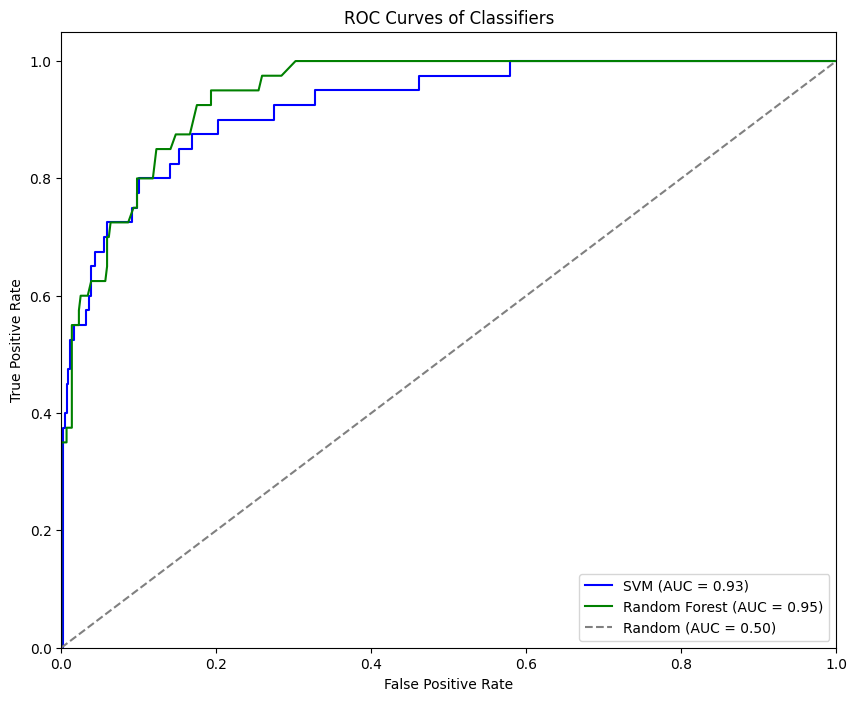

In [ ]:
y_proba_svm = svm_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve points
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

# Calculate the AUC (Area Under Curve) for each classifier
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='green')

# Plotting ROC for a random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Classifiers')
plt.legend(loc="lower right")
plt.show()

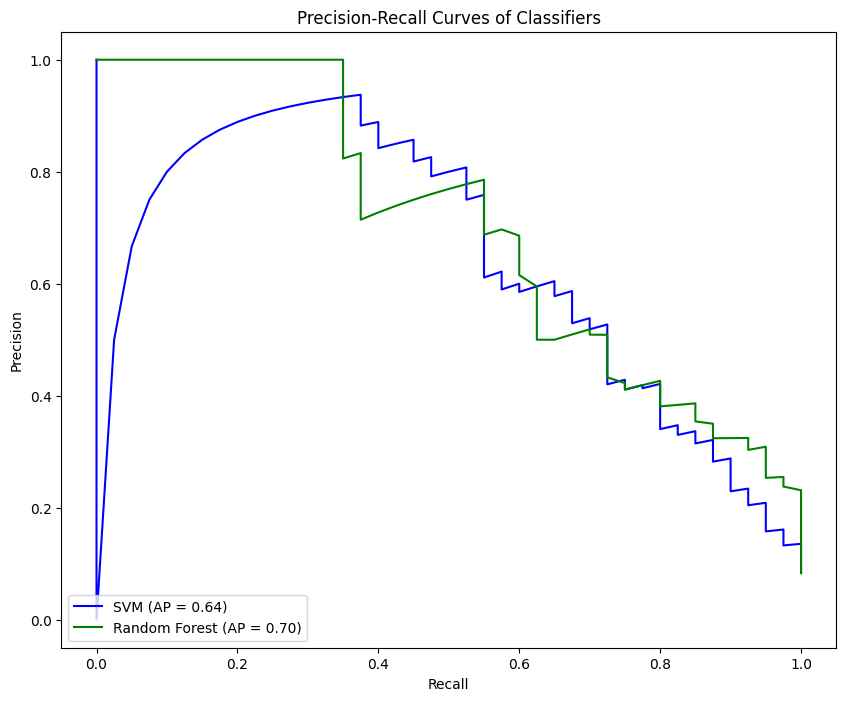

In [ ]:
y_proba_svm = svm_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]
y_proba_rf = rf_grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]

# Calculate Precision-Recall curve points
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_proba_svm)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

# Calculate the Average Precision (AP) for each classifier
ap_svm = average_precision_score(y_test, y_proba_svm)
ap_rf = average_precision_score(y_test, y_proba_rf)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(recall_svm, precision_svm, label=f'SVM (AP = {ap_svm:.2f})', color='blue')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {ap_rf:.2f})', color='green')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves of Classifiers')
plt.legend(loc="lower left")
plt.show()

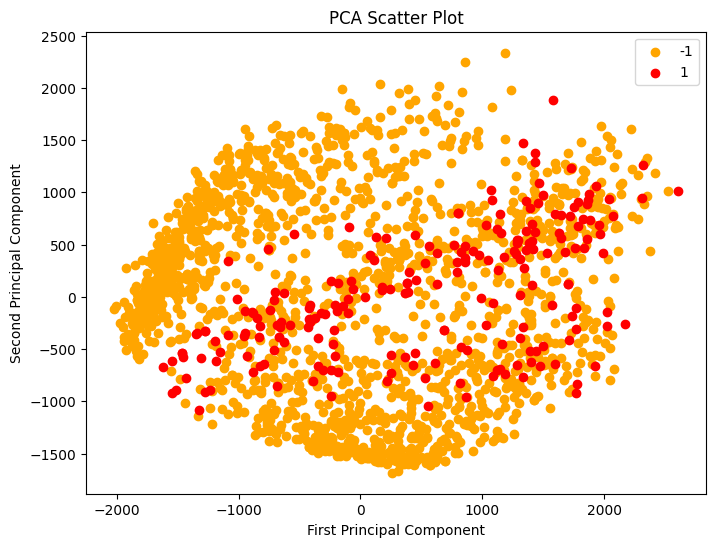

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xtrain)

# Convert to DataFrame for easier plotting
df_pca = pd.DataFrame(X_pca, columns=['First Principal Component', 'Second Principal Component'])
df_pca['Label'] = Ytrain

# Plotting
plt.figure(figsize=(8, 6))
for label, color in zip(df_pca['Label'].unique(), ['orange', 'red']):
    mask = df_pca['Label'] == label
    plt.scatter(df_pca.loc[mask, 'First Principal Component'],
                df_pca.loc[mask, 'Second Principal Component'],
                label=label,
                c=color)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

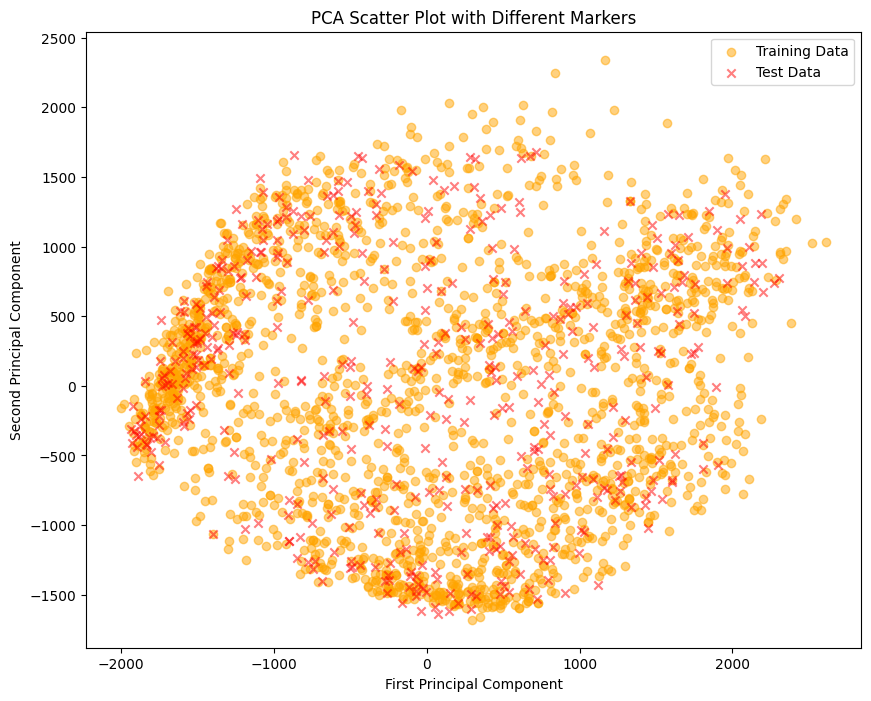

In [ ]:
# Combine the training and test sets for PCA
X_combined = np.vstack((Xtrain, Xtest))

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_combined_pca = pca.fit_transform(X_combined)

# Split the combined dataset back into training and test sets
X_train_pca = X_combined_pca[:Xtrain.shape[0], :]
X_test_pca = X_combined_pca[Xtrain.shape[0]:, :]

# Plot the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], color='orange', marker='o', label='Training Data', alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], color='red', marker='x', label='Test Data', alpha=0.5)
plt.title('PCA Scatter Plot with Different Markers')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.show()

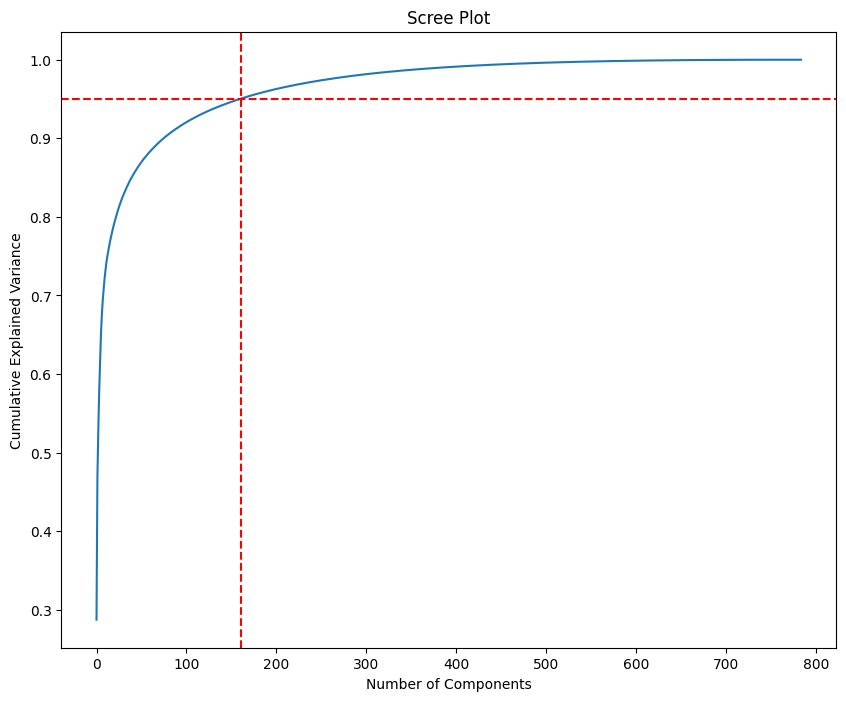

Number of dimensions that explain 95% variance: 161


In [ ]:
# Fit PCA on the training data
pca = PCA()
pca = PCA().fit(Xtrain)

# Calculate the cumulative sum of explained variances
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the scree graph
plt.figure(figsize = (10, 8))
plt.plot(cumulative_explained_variance)

# Draw a horizontal line at 0.95 (which corresponds to 95%)
plt.axhline(y = 0.95, color = 'r', linestyle = '--')

# Find the number of dimensions where cumulative explained variance is just over 95%
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
plt.axvline(x = num_components_95, color = 'r', linestyle = '--')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

print(f"Number of dimensions that explain 95% variance: {num_components_95}")

In [ ]:
# Split data for training and validation
from sklearn.pipeline import Pipeline
Xtrain, X_val, Ytrain, y_val = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

# Define a pipeline that includes PCA, standardization, and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svm', SVC(probability=True))
])

# Define the parameter grid
param_grid = {
    'pca__n_components': [20, 40, 60, 80],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'poly']
}

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(Xtrain, Ytrain)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)



Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'pca__n_components': 60, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9303206565421549


In [ ]:

# Load the training and test data from the uploaded files
Xtrain = pd.read_csv('/content/Xtrain.csv',header=None, delim_whitespace=True)
Ytrain = pd.read_csv('/content/Ytrain.csv',header=None, delim_whitespace=True)
Xtest = pd.read_csv('/content/Xtest.csv',header=None, delim_whitespace=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Xtrain)
X_test_scaled = scaler.transform(Xtest)

# Feature reduction with PCA based on prior analysis
pca = PCA(n_components = 60)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Setup pipeline with random forest classifier having params based on prior analysis
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(n_estimators = 200, max_depth = None))
])

# Fit and predict using trained model
pipeline.fit(X_train_pca, Ytrain)
predictions = pipeline.predict_proba(X_test_pca)[:, 1]

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('prediction.csv', index = False, header = False)


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [ ]:

Xtrain = pd.read_csv('/content/Xtrain.csv',header=None, delim_whitespace=True)
Ytrain = pd.read_csv('/content/Ytrain.csv',header=None, delim_whitespace=True)
Xtest = pd.read_csv('/content/Xtest.csv',header=None, delim_whitespace=True)
X_combined = np.vstack((Xtrain, Xtest))
y_combined = np.concatenate((-1 * np.ones(len(Xtrain)), np.ones(len(Xtest))))

# Initialize classifier
clf = RandomForestClassifier()

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate AUC-ROC scores using cross-validation
auc_scores = cross_val_score(clf, X_combined, y_combined, scoring='roc_auc', cv=cv)

# Compute average and standard deviation of AUC-ROC
auc_avg = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print(f"AUC-ROC Average: {auc_avg}, Standard Deviation: {auc_std}")

AUC-ROC Average: 0.999658611111111, Standard Deviation: 0.0006380020414844219
